# Classifying Coronavirus-Related Tweets Sentiment

- James M. Irving, Ph.D.
- 06/13/21

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.


- Dataset from Kaggle:
    - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification


# OBTAIN

In [1]:
from fsds.imports import *

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string


from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
# Visit https://spacy.io/usage for isntallation tool
# !python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
df = pd.read_csv("https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/raw/master/Phase_4/topic_42_tuning_neural_networks/data/cornavirus_tweets.csv.gz",
                 encoding='latin-1',parse_dates=['TweetAt'])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41154,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41155,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41156,44953,89905,NaN,2020-04-14,You know itÃÂs getting tough when @KameronWi...,Positive
41157,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41158 non-null  object        
 1   ScreenName     41158 non-null  object        
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41155 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.9+ MB


## Data

- Columns of interest are:
    - For NLP classification:
        - Sentiment
        - OriginalTweet,
    - For EDA:
        - Sentiment
        - Location
        - TweetAt
        

# SCRUB

In [5]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
UserName,1,0.00
ScreenName,1,0.00
Location,8592,20.88
TweetAt,2,0.00
OriginalTweet,2,0.00
Sentiment,4,0.01


- Drop nulls from subset=['OriginalTweet','Sentiment']
- Fill Nulls:
    - Location: "Unknown"

In [6]:
## deal with nulls and check
df['Location'].fillna('Unknown',inplace=True)
df.dropna(subset=['TweetAt','OriginalTweet','Sentiment'],inplace=True)

null_check(df)

,nulls,%null
UserName,0,0.0
ScreenName,0,0.0
Location,0,0.0
TweetAt,0,0.0
OriginalTweet,0,0.0
Sentiment,0,0.0


# EXPLORE

In [7]:
## How many unique users?
df['UserName'].nunique()

41155

In [8]:
## Are any users represented more than once?
user_counts = df["UserName"].value_counts()
user_counts[user_counts >1]

Series([], Name: UserName, dtype: int64)

In [9]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [10]:
## Make list of sentiments for ordering plots 
sentiment_order = ['Extremely Negative', 'Negative','Neutral',
                   'Positive','Extremely Positive']

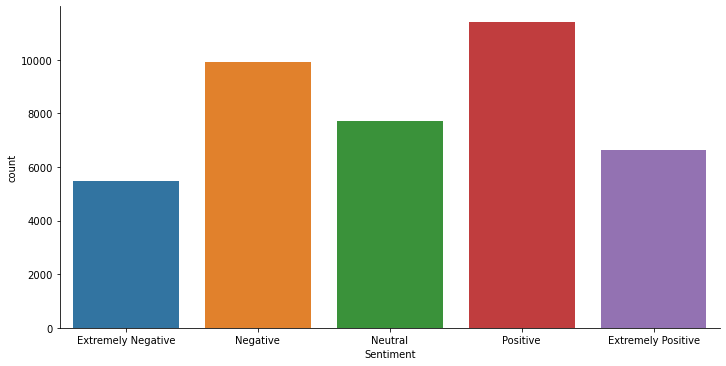

In [11]:
## Overall sentiment distribution
sns.catplot(data=df,x='Sentiment',kind='count',order=sentiment_order,aspect=2)

In [12]:
## How many locations?
location_counts = df['Location'].value_counts()
location_counts.head(40)

Unknown                    8593
London                      540
United States               528
London, England             520
New York, NY                395
Washington, DC              373
United Kingdom              337
Los Angeles, CA             281
India                       268
UK                          232
Australia                   225
USA                         223
England, United Kingdom     191
Canada                      190
Toronto, Ontario            160
Global                      159
Chicago, IL                 155
California, USA             153
San Francisco, CA           152
Boston, MA                  150
New York, USA               140
New Delhi, India            138
New York                    126
Atlanta, GA                 126
Mumbai, India               109
Worldwide                   101
Lagos, Nigeria               99
Houston, TX                  98
Austin, TX                   98
Texas, USA                   98
London, UK                   96
Toronto 

> - Will analyze locations with more than 100 tweets.

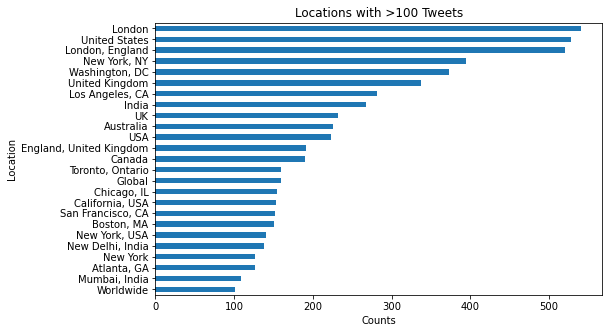

In [13]:
## Visualize locations with >100 tweets
frequent_locations = location_counts[(location_counts>100)&(location_counts<6000)]
ax = frequent_locations.sort_values().plot(kind='barh',figsize=(8,5))
ax.set(xlabel='Counts',ylabel='Location',title='Locations with >100 Tweets');

In [14]:
df_freq_location = df[df['Location'].isin(frequent_locations.index)]
df_freq_location

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
13,3812,48764,"Chicago, IL",2020-03-16,"Me: I don't need to stock up on food, I'll jus...",Positive
21,3820,48772,Global,2020-03-16,https://t.co/AVKrR9syff\r\r\n\r\r\nThe COVID-1...,Neutral
25,3824,48776,London,2020-03-16,UK #consumer poll indicates the majority expec...,Extremely Positive
...,...,...,...,...,...,...
41134,44931,89883,"Mumbai, India",2020-04-14,Question on @Quora: Is there any way to buy an...,Neutral
41137,44934,89886,"New York, NY",2020-04-14,"As physical stores close, clothing retailers a...",Positive
41140,44937,89889,"Los Angeles, CA",2020-04-14,HMU FOR PRICES!! Got great deals going right n...,Extremely Positive
41143,44940,89892,India,2020-04-14,#Coronavirus ?? ????? ??? ????? ?? ??? ???????...,Neutral


### Sentiment Word Usage

In [15]:
## save a dictionary with each sentiment
sent_dict = {}
for sentiment in df["Sentiment"].unique():
    sent_dict[sentiment] = df[ df['Sentiment']==sentiment]
    
sent_dict.keys()

dict_keys(['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'])

In [16]:
## combining negative and extremely neg for EDA
neg_sents = pd.concat([sent_dict['Negative'],sent_dict['Extremely Negative']])
pos_sents = pd.concat([sent_dict['Positive'],sent_dict['Extremely Positive']])

neg_sents

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9,3808,48760,"BHAVNAGAR,GUJRAT",2020-03-16,"For corona prevention,we should stop to buy th...",Negative
24,3823,48775,Downstage centre,2020-03-16,@10DowningStreet @grantshapps what is being do...,Negative
26,3825,48777,"Ketchum, Idaho",2020-03-16,In preparation for higher demand and a potenti...,Negative
28,3827,48779,"New York, NY",2020-03-16,Do you see malicious price increases in NYC? T...,Negative
30,3829,48781,Unknown,2020-03-16,There Is of in the Country The more empty she...,Negative
...,...,...,...,...,...,...
41117,44914,89866,Unknown,2020-04-14,Food Banks are not equipped for a 30% unemploy...,Extremely Negative
41130,44927,89879,"Melbourne, Australia",2020-04-14,The COVID-19 pandemic and global oil price war...,Extremely Negative
41132,44929,89881,Unknown,2020-04-14,Squeo works in the meat department of a Kroger...,Extremely Negative
41135,44932,89884,Austria,2020-04-14,A Singaporean politician who slammed a woman s...,Extremely Negative


In [17]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer(preserve_case=False)

In [18]:
## save stopwords
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(['http','https','co'])

In [19]:
## save neg_corpus and remove stopwords
neg_corpus = tokenizer.tokenize(' '.join(neg_sents["OriginalTweet"]))
neg_corpus = [w for w in neg_corpus if w not in stopwords_list]
neg_corpus[:10]

['corona',
 'prevention',
 'stop',
 'buy',
 'things',
 'cash',
 'use',
 'online',
 'payment',
 'methods']

In [20]:
## save pos_corpus and remove stopwords
pos_corpus = tokenizer.tokenize(' '.join(pos_sents["OriginalTweet"]))
pos_corpus = [w for w in pos_corpus if w not in stopwords_list]
pos_corpus[:10]

['advice',
 'talk',
 'neighbours',
 'family',
 'exchange',
 'phone',
 'numbers',
 'create',
 'contact',
 'list']

In [21]:
pos_freq = nltk.FreqDist(pos_corpus)
pos_freq.most_common(25)

[('#coronavirus', 6761),
 ('19', 5380),
 ('â', 5318),
 ('\x82', 5248),
 ('covid', 4639),
 ('store', 3295),
 ('\x92', 3120),
 ('prices', 2954),
 ('grocery', 2939),
 ('supermarket', 2875),
 ('food', 2703),
 ('people', 2260),
 ('#covid19', 2223),
 ('consumer', 1961),
 ('hand', 1783),
 ('online', 1763),
 ('shopping', 1692),
 ('help', 1689),
 ('like', 1689),
 ('sanitizer', 1632),
 ('workers', 1509),
 ('ã', 1461),
 ('get', 1364),
 ('#covid_19', 1340),
 ('...', 1329)]

(-0.5, 1199.5, 799.5, -0.5)

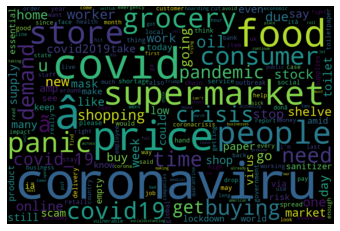

In [22]:
# plot negative words
wordcloud_gen = WordCloud(collocations=False,stopwords=stopwords_list,
                          width=1200,height=800)
neg_cloud = wordcloud_gen.generate(' ' .join(neg_corpus))

plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 1199.5, 799.5, -0.5)

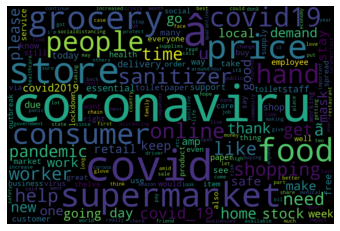

In [23]:
# plot negative words
pos_cloud = wordcloud_gen.generate(' ' .join(pos_corpus))

plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off")

# MODEL

## Make X,y + train_test_spit

In [24]:
## Make a dict mapper for target
target_map = dict(zip(sentiment_order,range(len(sentiment_order)+1)))
target_map

{'Extremely Negative': 0,
 'Negative': 1,
 'Neutral': 2,
 'Positive': 3,
 'Extremely Positive': 4}

In [25]:
## mapper for Simpler 3-class target
target_map_3class = {'Extremely Negative':0, 
                     'Negative':0,
                     'Neutral':1, 
                     'Positive':2,
                     'Extremely Positive':2}
target_map_3class

{'Extremely Negative': 0,
 'Negative': 0,
 'Neutral': 1,
 'Positive': 2,
 'Extremely Positive': 2}

In [26]:
X = df['OriginalTweet'].copy()
y = df['Sentiment'].map(target_map)
y.value_counts(1)

3    0.277536
1    0.240967
2    0.187365
4    0.160952
0    0.133179
Name: Sentiment, dtype: float64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=321)


In [28]:
from sklearn import set_config
set_config(display='diagram')

In [29]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
text_pipe = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
                                 stop_words=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
text_pipe

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fa3275abd30>>)),
                ('tfidf', TfidfTransformer())])

In [30]:
X_train_vec = text_pipe.fit_transform(X_train)
X_test_vec = text_pipe.transform(X_test)

In [31]:
X_train_vec

<30866x72051 sparse matrix of type '<class 'numpy.float64'>'
	with 586498 stored elements in Compressed Sparse Row format>

## Model Evaluation Functions

In [32]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        

    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance



## Model 1: LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics

### Vanilla LogReg, no regularization

              precision    recall  f1-score   support

           0       0.62      0.57      0.60      1429
           1       0.49      0.50      0.49      2513
           2       0.59      0.55      0.57      1913
           3       0.50      0.53      0.52      2766
           4       0.63      0.63      0.63      1668

    accuracy                           0.55     10289
   macro avg       0.57      0.56      0.56     10289
weighted avg       0.55      0.55      0.55     10289



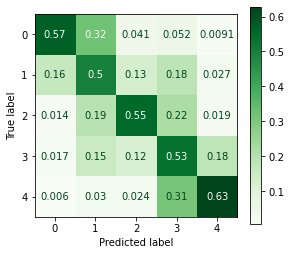

Training Score = 1.00
Test Score = 0.55


In [34]:
clf = LogisticRegression(C=1e12,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

### GridSearch for C

In [35]:
# clf = LogisticRegressionCV(class_weight='balanced',max_iter=300,cv=3,
#                            scoring='recall_macro',n_jobs=-1,verbose=2)
# clf.fit(X_train_vec,y_train)
# evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

## RandomForest

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      1429
           1       0.48      0.45      0.46      2513
           2       0.51      0.76      0.61      1913
           3       0.45      0.55      0.50      2766
           4       0.70      0.36      0.48      1668

    accuracy                           0.51     10289
   macro avg       0.56      0.50      0.51     10289
weighted avg       0.54      0.51      0.51     10289



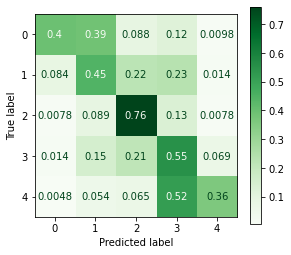

Training Score = 1.00
Test Score = 0.51


In [36]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.